In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Weddell_Extent = pd.read_excel(filepath, sheet_name='Weddell-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Weddell_Extent)
fp.date_time(Weddell_Extent)

,Extent,Date
0,2136510.859,1979-01-01
1,1243495.891,1979-02-01
2,1699053.449,1979-03-01
3,2617442.085,1979-04-01
4,3852934.206,1979-05-01
...,...,...
533,3668127.143,2023-06-01
534,4805519.784,2023-07-01
535,5524445.234,2023-08-01
536,6006669.861,2023-09-01


In [5]:
scaler = MinMaxScaler()
Weddell_Extent['Extent'] = scaler.fit_transform(Weddell_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 4
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Weddell_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((523, 12, 1), (523,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Weddell_model_LT4/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 13s 168ms/step - loss: 0.3010 - root_mean_squared_error: 0.5486 - val_loss: 0.2196 - val_root_mean_squared_error: 0.4686
Epoch 2/50
53/53 [==============================] - 7s 140ms/step - loss: 0.1358 - root_mean_squared_error: 0.3686 - val_loss: 0.0583 - val_root_mean_squared_error: 0.2414
Epoch 3/50
53/53 [==============================] - 7s 135ms/step - loss: 0.0557 - root_mean_squared_error: 0.2361 - val_loss: 0.0486 - val_root_mean_squared_error: 0.2204
Epoch 4/50
53/53 [==============================] - 8s 152ms/step - loss: 0.0479 - root_mean_squared_error: 0.2188 - val_loss: 0.0414 - val_root_mean_squared_error: 0.2035
Epoch 5/50
53/53 [==============================] - 7s 134ms/step - loss: 0.0395 - root_mean_squared_error: 0.1988 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1816
Epoch 6/50
53/53 [==============================] - 7s 132ms/step - loss: 0.0332 - root_mean_squared_error: 0.1823 - val_loss: 0.0271 - val

Epoch 28/50
53/53 [==============================] - 1s 24ms/step - loss: 0.0120 - root_mean_squared_error: 0.1095 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0882
Epoch 29/50
53/53 [==============================] - 6s 121ms/step - loss: 0.0120 - root_mean_squared_error: 0.1096 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0817
Epoch 30/50
53/53 [==============================] - 8s 156ms/step - loss: 0.0108 - root_mean_squared_error: 0.1037 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0809
Epoch 31/50
53/53 [==============================] - 8s 148ms/step - loss: 0.0103 - root_mean_squared_error: 0.1015 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0800
Epoch 32/50
53/53 [==============================] - 1s 22ms/step - loss: 0.0107 - root_mean_squared_error: 0.1035 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0801
Epoch 33/50
53/53 [==============================] - 7s 140ms/step - loss: 0.0099 - root_mean_squared_error: 0.0994 - val_loss: 0.0058 - 

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

4.558019757270813 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

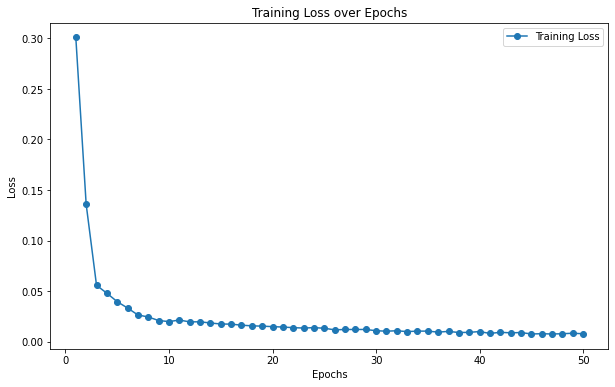

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

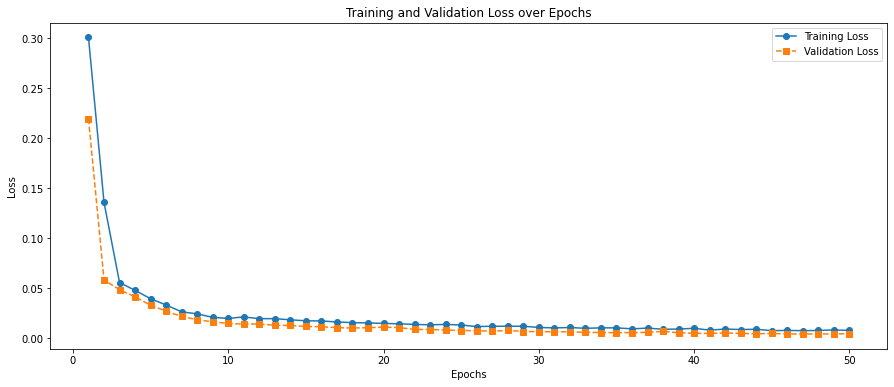

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Weddell_model_LT4/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 12ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.07392073568946952
MAE : 0.05498788876874368


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,5.430320e+06,6574288.749
1,5.685114e+06,6669726.076
2,5.440459e+06,6516136.854
3,4.615948e+06,5902163.675
4,3.358428e+06,3498103.449
5,1.904803e+06,1633675.726
6,1.049802e+06,1292668.399
7,1.118217e+06,1527666.815
8,2.042880e+06,2121949.701
9,3.105063e+06,3562381.775


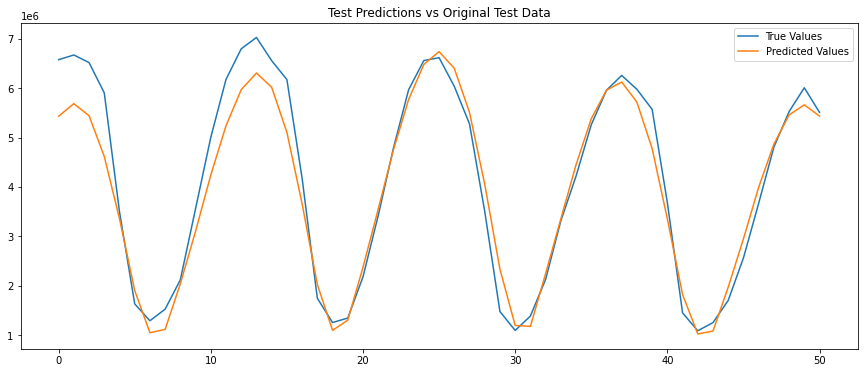

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 12ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

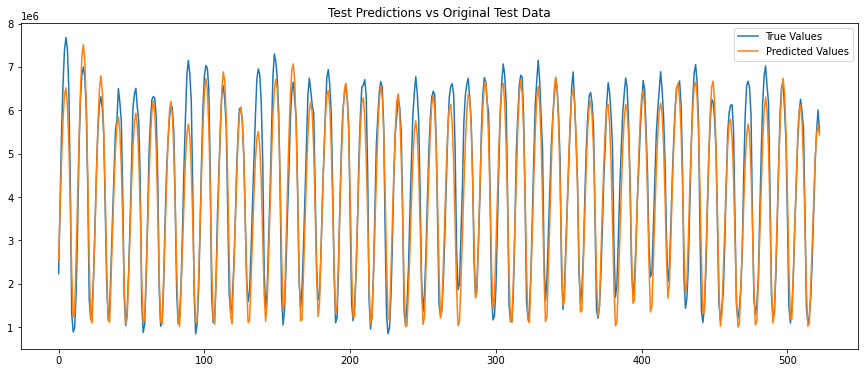

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()